<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/SVM(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SVM CROP PRODUCTION CLASSIFICATION PIPELINE
Loading datasets...
Train dataset shape: (3584, 84)
Validation dataset shape: (768, 84)
Test dataset shape: (768, 84)
Creating labels based on quantiles...
Quantile boundaries: Low < 1030.000, Medium: 1030.000-3800.160, High > 3800.160
Train label distribution:
label
high      1221
low       1188
medium    1175
Name: count, dtype: int64

Val label distribution:
label
high      263
medium    255
low       250
Name: count, dtype: int64

Test label distribution:
label
medium    258
high      257
low       253
Name: count, dtype: int64

Feature matrix shape: (3584, 83)
Number of features: 83
Scaling features...
Data preprocessing completed!

TRAINING PHASE
Training SVM with 15 different C values (simulating epochs)...
Epoch 1/15 - C: 0.001000 - Train Acc: 0.3407 - Val Acc: 0.3424
Epoch 2/15 - C: 0.002276 - Train Acc: 0.3407 - Val Acc: 0.3424
Epoch 3/15 - C: 0.005179 - Train Acc: 0.3407 - Val Acc: 0.3424
Epoch 4/15 - C: 0.011788 - Train Acc: 0.342

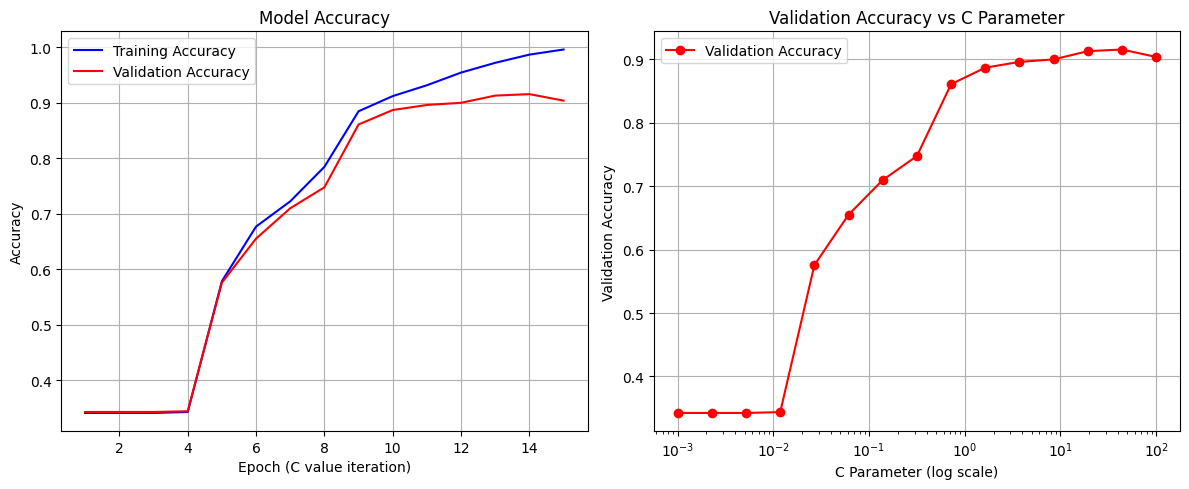

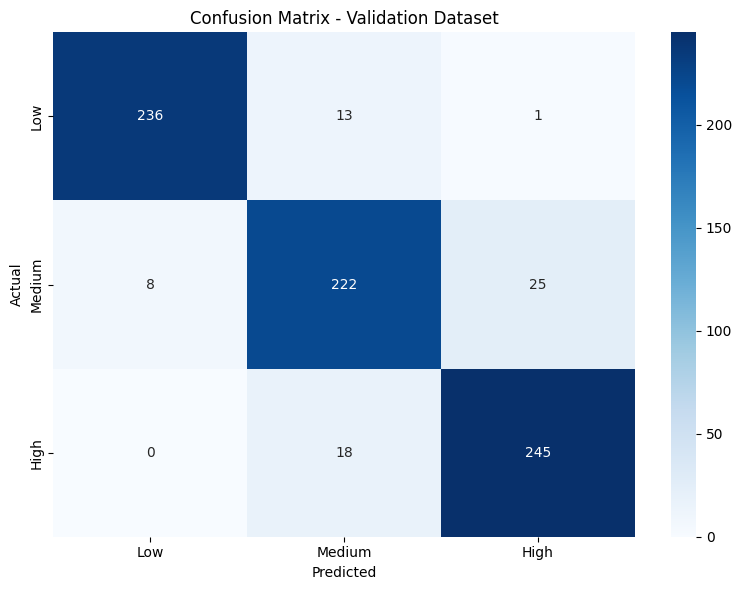

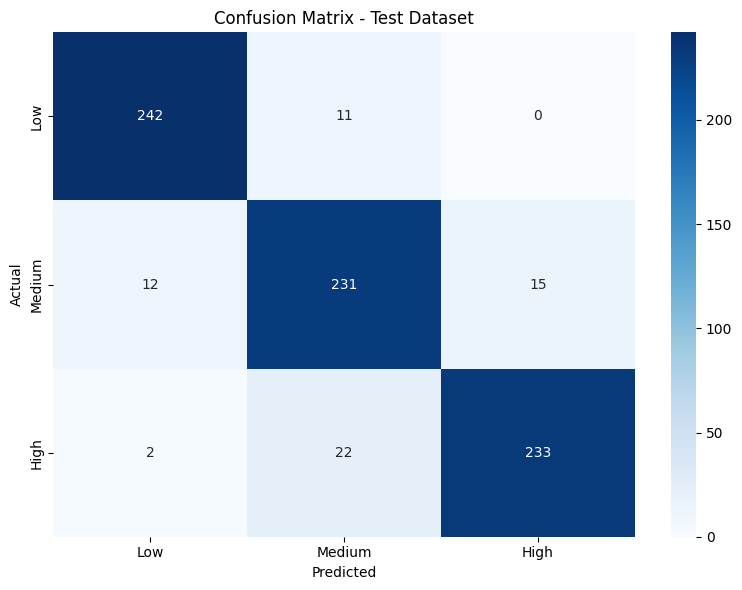


FINAL SUMMARY
Validation Macro F1 Score: 0.9157
Test Macro F1 Score: 0.9196
Validation Accuracy: 0.9154
Test Accuracy: 0.9193

ADDITIONAL ANALYSIS
Number of support vectors: [455 625 479]
Support vector indices: 1559

5-Fold Cross-Validation Macro F1 Scores: [0.91667002 0.91345076 0.90501219 0.9032162  0.91360879]
Mean CV Macro F1 Score: 0.9104 (+/- 0.0106)


In [ ]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

# Step 2: Set random seed for reproducibility
np.random.seed(42)

# Step 3: Create the main SVM classifier class
class SVMCropProductionClassifier:

    # Step 4: Initialize the class with default values
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_mapping = {'low': 0, 'medium': 1, 'high': 2}
        self.reverse_label_mapping = {0: 'low', 1: 'medium', 2: 'high'}
        self.training_history = {'train_acc': [], 'val_acc': []}

    # Step 5: Load and preprocess the datasets
    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        self.train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        self.val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        self.test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"Train dataset shape: {self.train_df.shape}")
        print(f"Validation dataset shape: {self.val_df.shape}")
        print(f"Test dataset shape: {self.test_df.shape}")

        # Create labels based on quantiles
        self._create_labels()

        # Prepare features and labels
        self._prepare_features_labels()

        # Scale features
        self._scale_features()

        print("Data preprocessing completed!")

    # Step 6: Create classification labels based on production quantiles
    def _create_labels(self):
        """Create labels based on quantiles of production data"""
        print("Creating labels based on quantiles...")

        # Combine all production data to calculate consistent quantiles
        all_production = pd.concat([
            self.train_df['Production (M.Ton)'],
            self.val_df['Production (M.Ton)'],
            self.test_df['Production (M.Ton)']
        ])

        # Calculate quantiles
        q33 = all_production.quantile(0.33)
        q66 = all_production.quantile(0.66)

        print(f"Quantile boundaries: Low < {q33:.3f}, Medium: {q33:.3f}-{q66:.3f}, High > {q66:.3f}")

        # Create labels for each dataset
        for df, name in [(self.train_df, 'train'), (self.val_df, 'val'), (self.test_df, 'test')]:
            df['label'] = pd.cut(df['Production (M.Ton)'],
                               bins=[-np.inf, q33, q66, np.inf],
                               labels=['low', 'medium', 'high'])

            # Print label distribution
            print(f"{name.capitalize()} label distribution:")
            print(df['label'].value_counts())
            print()

    # Step 7: Prepare features and labels for machine learning
    def _prepare_features_labels(self):
        """Prepare features and labels for training"""
        # Remove the target column and label column to get features
        feature_cols = [col for col in self.train_df.columns if col not in ['Production (M.Ton)', 'label']]

        # Prepare training data
        self.X_train = self.train_df[feature_cols].values
        self.y_train = self.train_df['label'].map(self.label_mapping).values

        # Prepare validation data
        self.X_val = self.val_df[feature_cols].values
        self.y_val = self.val_df['label'].map(self.label_mapping).values

        # Prepare test data
        self.X_test = self.test_df[feature_cols].values
        self.y_test = self.test_df['label'].map(self.label_mapping).values

        print(f"Feature matrix shape: {self.X_train.shape}")
        print(f"Number of features: {len(feature_cols)}")

    # Step 8: Scale/normalize features using StandardScaler
    def _scale_features(self):
        """Scale features using StandardScaler"""
        print("Scaling features...")

        # Fit scaler on training data and transform all datasets
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

    # Step 9: Train SVM with different C values (hyperparameter tuning)
    def train_with_validation(self, C_values=None, epochs=10):
        """Train SVM with different C values to simulate epochs"""
        if C_values is None:
            # Create a range of C values to simulate training epochs
            C_values = np.logspace(-3, 2, epochs)

        print(f"Training SVM with {len(C_values)} different C values (simulating epochs)...")

        best_val_acc = 0
        best_C = None

        for i, C in enumerate(C_values):
            # Train SVM with current C value
            model = SVC(C=C, kernel='rbf', random_state=42)
            model.fit(self.X_train_scaled, self.y_train)

            # Calculate accuracies
            train_acc = model.score(self.X_train_scaled, self.y_train)
            val_acc = model.score(self.X_val_scaled, self.y_val)

            # Store training history
            self.training_history['train_acc'].append(train_acc)
            self.training_history['val_acc'].append(val_acc)

            # Keep track of best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_C = C
                self.model = model

            print(f"Epoch {i+1}/{len(C_values)} - C: {C:.6f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        print(f"\nBest validation accuracy: {best_val_acc:.4f} with C: {best_C:.6f}")

        # Train final model with best C
        self.model = SVC(C=best_C, kernel='rbf', random_state=42)
        self.model.fit(self.X_train_scaled, self.y_train)

    # Step 10: Evaluate model performance on any dataset
    def evaluate_model(self, X, y, dataset_name):
        """Evaluate model and return metrics"""
        y_pred = self.model.predict(X)

        # Calculate metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        f1_weighted = f1_score(y, y_pred, average='weighted')
        f1_macro = f1_score(y, y_pred, average='macro')

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro
        }

        print(f"\n{dataset_name} Dataset Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")

        # Detailed classification report
        print(f"\nDetailed Classification Report for {dataset_name}:")
        target_names = ['Low', 'Medium', 'High']
        print(classification_report(y, y_pred, target_names=target_names))

        return metrics, y_pred

    # Step 11: Plot confusion matrix for model predictions
    def plot_confusion_matrix(self, y_true, y_pred, dataset_name):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)

        # Create labels
        labels = ['Low', 'Medium', 'High']

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels)
        plt.title(f'Confusion Matrix - {dataset_name} Dataset')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    # Step 12: Plot training history and C parameter analysis
    def plot_training_history(self):
        """Plot training and validation accuracy"""
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        epochs = range(1, len(self.training_history['train_acc']) + 1)
        plt.plot(epochs, self.training_history['train_acc'], 'b-', label='Training Accuracy')
        plt.plot(epochs, self.training_history['val_acc'], 'r-', label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch (C value iteration)')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Plot C values used
        plt.subplot(1, 2, 2)
        C_values = np.logspace(-3, 2, len(epochs))
        plt.semilogx(C_values, self.training_history['val_acc'], 'ro-', label='Validation Accuracy')
        plt.title('Validation Accuracy vs C Parameter')
        plt.xlabel('C Parameter (log scale)')
        plt.ylabel('Validation Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Step 13: Run the complete machine learning pipeline
    def run_complete_pipeline(self, train_path, val_path, test_path, epochs=10):
        """Run the complete pipeline"""
        print("="*60)
        print("SVM CROP PRODUCTION CLASSIFICATION PIPELINE")
        print("="*60)

        # Step 1: Load and preprocess data
        self.load_and_preprocess_data(train_path, val_path, test_path)

        # Step 2: Train model with validation
        print("\n" + "="*50)
        print("TRAINING PHASE")
        print("="*50)
        self.train_with_validation(epochs=epochs)

        # Step 3: Evaluate on validation set
        print("\n" + "="*50)
        print("VALIDATION EVALUATION")
        print("="*50)
        val_metrics, val_pred = self.evaluate_model(self.X_val_scaled, self.y_val, "Validation")

        # Step 4: Evaluate on test set
        print("\n" + "="*50)
        print("TEST EVALUATION")
        print("="*50)
        test_metrics, test_pred = self.evaluate_model(self.X_test_scaled, self.y_test, "Test")

        # Step 5: Plot results
        print("\n" + "="*50)
        print("VISUALIZATION")
        print("="*50)

        # Plot training history
        self.plot_training_history()

        # Plot confusion matrices
        self.plot_confusion_matrix(self.y_val, val_pred, "Validation")
        self.plot_confusion_matrix(self.y_test, test_pred, "Test")

        # Summary
        print("\n" + "="*50)
        print("FINAL SUMMARY")
        print("="*50)
        print(f"Validation Macro F1 Score: {val_metrics['f1_macro']:.4f}")
        print(f"Test Macro F1 Score: {test_metrics['f1_macro']:.4f}")
        print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")

        return val_metrics, test_metrics

# Step 14: Main execution block
if __name__ == "__main__":
    # Initialize the classifier
    classifier = SVMCropProductionClassifier()

    # Define file paths
    train_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv'
    val_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv'
    test_path = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'

    # Run the complete pipeline
    val_metrics, test_metrics = classifier.run_complete_pipeline(
        train_path, val_path, test_path, epochs=15
    )

    # Step 15: Additional analysis and cross-validation
    print("\n" + "="*50)
    print("ADDITIONAL ANALYSIS")
    print("="*50)

    # Since SVM doesn't provide direct feature importance, we can look at support vectors
    print(f"Number of support vectors: {classifier.model.n_support_}")
    print(f"Support vector indices: {len(classifier.model.support_)}")

    # You can also perform cross-validation for more robust evaluation
    from sklearn.model_selection import cross_val_score

    # Combine train and validation for cross-validation
    X_combined = np.vstack([classifier.X_train_scaled, classifier.X_val_scaled])
    y_combined = np.hstack([classifier.y_train, classifier.y_val])

    cv_scores = cross_val_score(classifier.model, X_combined, y_combined, cv=5, scoring='f1_macro')
    print(f"\n5-Fold Cross-Validation Macro F1 Scores: {cv_scores}")
    print(f"Mean CV Macro F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")